# Super Bowl Squares

## Second notebook: Dataframe of all scores since 1994 season
We'll concatenate the five csv's we scraped in the first notebook to get a dataframe of 872 rows. The goal of this notebook is to get a dataframe of 100 rows representing each possible last-digit score combination (i.e. Winner "9" Loser "6", Winner "4" Loser "7") along with the count of that combination.

In [238]:
import numpy as np
import pandas as pd

In [239]:
csv_strings = ['first_10_scores.csv', 'second_20_scores.csv', 'next_495.csv', 'next_235.csv', 'last_112.csv']

In [240]:
list_of_dfs = []
for name in csv_strings:
    temp_df = pd.read_csv(name)
    list_of_dfs.append(temp_df)

In [241]:
scores_df = pd.concat(list_of_dfs)

In [242]:
scores_df.head()

,Unnamed: 0,WScore,LScore,WLastDig,LLastDig,Count
0,0,20,17,0,7,148
1,1,27,24,7,4,130
2,2,17,14,7,4,59
3,3,23,20,3,0,134
4,4,24,17,4,7,101


In [243]:
len(scores_df)

872

In [244]:
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872 entries, 0 to 111
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  872 non-null    int64
 1   WScore      872 non-null    int64
 2   LScore      872 non-null    int64
 3   WLastDig    872 non-null    int64
 4   LLastDig    872 non-null    int64
 5   Count       872 non-null    int64
dtypes: int64(6)
memory usage: 47.7 KB


In [245]:
scores_df.tail()

,Unnamed: 0,WScore,LScore,WLastDig,LLastDig,Count
107,107,28,2,8,2,1
108,108,56,31,6,1,1
109,109,55,31,5,1,1
110,110,51,28,1,8,1
111,111,53,32,3,2,1


# Summing up the Count column
We'll sum the Count column, and that should give us the total of games played since the start of the 1994 season. Again, we're starting at 1994 because that was the first year two-point conversions were allowed in the NFL. We want to assess the probability of each Super Bowl square hitting, and two-point conversions affect those probabilities. 

We'll have to figure out exactly how many games have been played since 1994. We can do that by looking up how many teams were in the NFL in each of those seasons along with how many regular-season and playoff games were played.

<b>1994:</b> 28 teams 14 games times 16 weeks = 224 + 11 playoff games = 235<br>
<b>1995-98:</b> 30 teams 15 games times 16 weeks = 240 + 11 playoff games = 251 * 4 = 1004<br>
<b>1999-01:</b> 31 teams 10 weeks *  15 games +  7 weeks * 14 games = 248 + 11 = 259 * 3 = 777<br>
<b>2002-2019:</b> 32 teams 16 games times 16 weeks = 256 + 11 = 267 * 18 = 4806<br>
<b>2020:</b> (2 more playoff games): 256 + 13 = 269<br>
<b>2021:</b> 2 more regular-season games 16 * 17 = 272 + 13 = 285<br>
<b>2022:</b> all games except Super Bowl = 284<br>

This all added up to 7660, then we have to subtract one because the game in which Damar Hamlin suffered cardiac arrest on the field was never completed.


In [246]:
scores_df['Count'].sum()

7659

# Bingo!
Great. So every score that has occurred since the beginning of the 1994 season is accounted for. Next, we'll drop that Unnamed: 0 column that always seems to come up after we read a csv into a notebook, and also the full scores with both digits.

In [247]:
scores_df = scores_df.drop(columns = ['Unnamed: 0', 'WScore', 'LScore'])

In [248]:
scores_df.head()

,WLastDig,LLastDig,Count
0,0,7,148
1,7,4,130
2,7,4,59
3,3,0,134
4,4,7,101


# Groupby
Now, we'll group by the first two columns to get a sum of every combination of last digits in scores.

In [249]:
scores_df_grouped = scores_df.groupby(['WLastDig', 'LLastDig']).sum().reset_index()

In [250]:
scores_df_grouped.head()

,WLastDig,LLastDig,Count
0,0,0,145
1,0,1,20
2,0,2,37
3,0,3,187
4,0,4,97


In [251]:
scores_df_grouped.tail()

,WLastDig,LLastDig,Count
95,9,5,11
96,9,6,78
97,9,7,92
98,9,8,18
99,9,9,22


# Testing
Now we'll test five random rows, using the ungrouped dataframe, just to make sure it's right. We'll also check the length of the dataframe, which should be 100. It all checks out.

In [252]:
scores_df[(scores_df['WLastDig'] == 0) & (scores_df['LLastDig'] == 7)]['Count'].sum()

302

In [253]:
scores_df[(scores_df['WLastDig'] == 8) & (scores_df['LLastDig'] == 7)]['Count'].sum()

111

In [254]:
scores_df[(scores_df['WLastDig'] == 1) & (scores_df['LLastDig'] == 1)]['Count'].sum()

58

In [255]:
scores_df[(scores_df['WLastDig'] == 2) & (scores_df['LLastDig'] == 9)]['Count'].sum()

41

In [256]:
scores_df[(scores_df['WLastDig'] == 4) & (scores_df['LLastDig'] == 5)]['Count'].sum()

14

In [257]:
len(scores_df_grouped)

100

# Changing columns to strings and renaming to AFC and NFC
First the easy part. We're changing the numbers in the first two columns to strings as they are now essentially categories. We don't want Tableau to read them as measures.

Now the tricky part. The columns currently represent last digits of each winning score and last digits of each losing score. For our final visual, we want the axes on the grid to be 'AFC' and 'NFC.' We have to arbitrarily assign AFC to one column and NFC to another. When we first did that, it created a problem.

AFC 3, NFC 4 didn't have the same count as AFC 4, NFC 3, for example. We assigned AFC to the Winning Score column, and it might be more probable that a winning team will have a score that ends in 4 and a losing team will have a score that ends in 3 than the other way around. However, when we're picking Super Bowl squares BEFORE the Super Bowl, we don't know who's going to win. The probability of AFC 2, NFC 6, for example, should be equal to the probability of AFC 6, NFC 2.

Here's the heatmap that visualizes this problem. AFC 4, NFC 0, for example, is darker than NFC 4, AFC 0.

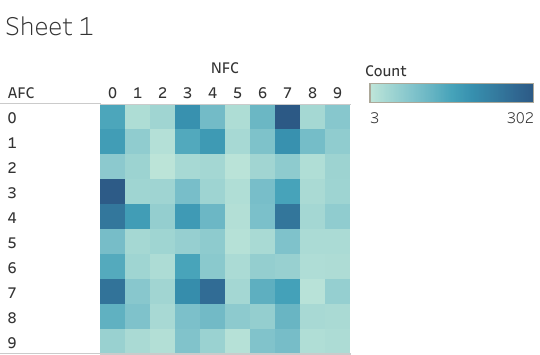

First we'll do the grouping and conversion to strings then figure out how to solve this problem.

In [258]:
scores_df_grouped = scores_df_grouped.rename(columns = {'WLastDig':'AFC', 'LLastDig':'NFC'})

In [259]:
scores_df_grouped['AFC'] = scores_df_grouped['AFC'].astype(str)
scores_df_grouped['NFC'] = scores_df_grouped['NFC'].astype(str)

In [260]:
scores_df_grouped.head(25)

,AFC,NFC,Count
0,0,0,145
1,0,1,20
2,0,2,37
3,0,3,187
4,0,4,97
5,0,5,20
6,0,6,108
7,0,7,302
8,0,8,31
9,0,9,70


# New order
The best way we can think of to replicate an AFC column and an NFC column in a situation where we don't know the winner is to re-order the dataframe, pair together symmetric digits such as AFC 5, NFC 7 and AFC 7, NFC 5, average those two counts and assign that average to each row's count value. Since we won't be pairing rows with same digits, we'll create a new dataframe with the first nine rows as 0, 11, 22 and so on.

Luckily the row indexes match the last digits of each of the two columns. So we created a second list that represents the order in which the rest of the rows should be appended to the new dataframe. We tried to use a for loop, but by the time we figured out the logic we had most of the numbers written out anyway.

In [261]:
first_10_rows = [0, 11, 22, 33, 44, 55, 66, 77, 88, 99]

In [262]:
last_90_rows = [1, 10, 2, 20, 3, 30, 4, 40, 5, 50, 6, 60, 7, 70, 8, 80, 9, 90,\
             12, 21, 13, 31, 14, 41, 15, 51, 16, 61, 17, 71, 18, 81, 19, 91,\
             23, 32, 24, 42, 25, 52, 26, 62, 27, 72, 28, 82, 29, 92,\
             34, 43, 35, 53, 36, 63, 37, 73, 38, 83, 39, 93,\
             45, 54, 46, 64, 47, 74, 48, 84, 49, 94,\
             56, 65, 57, 75, 58, 85, 59, 95,\
             67, 76, 68, 86, 69, 96, 78, 87, 79, 97, 89, 98]

In [263]:
scores_df_paired = pd.DataFrame()



In [264]:
for i in range(len(first_10_rows)):
    scores_df_paired = scores_df_paired.append(scores_df_grouped.iloc[first_10_rows[i], :], ignore_index = True)
    

In [265]:
scores_df_paired

,AFC,Count,NFC
0,0,145.0,0
1,1,58.0,1
2,2,3.0,2
3,3,90.0,3
4,4,106.0,4
5,5,11.0,5
6,6,53.0,6
7,7,155.0,7
8,8,28.0,8
9,9,22.0,9


In [266]:
for i in range(len(last_90_rows)):
    scores_df_paired = scores_df_paired.append(scores_df_grouped.iloc[last_90_rows[i], :], ignore_index = True)

In [267]:
scores_df_paired.head(25)

,AFC,Count,NFC
0,0,145.0,0
1,1,58.0,1
2,2,3.0,2
3,3,90.0,3
4,4,106.0,4
5,5,11.0,5
6,6,53.0,6
7,7,155.0,7
8,8,28.0,8
9,9,22.0,9


In [268]:
scores_df_paired['Adj_Count'] = scores_df_paired['Count']

In [269]:
scores_df_paired.tail(25)

,AFC,Count,NFC,Adj_Count
75,7,261.0,4,261.0
76,4,33.0,8,33.0
77,8,99.0,4,99.0
78,4,58.0,9,58.0
79,9,45.0,4,45.0
80,5,26.0,6,26.0
81,6,24.0,5,24.0
82,5,81.0,7,81.0
83,7,33.0,5,33.0
84,5,24.0,8,24.0


# Two-by-two
This loop goes through the new scores_df_paired dataframe in increments of two, averages every two rows and assigns that average to a new column, Adj_Count. Then we see that the sum of Adj_Count is still that magic number, 7659.

In [270]:
for i in range(10, len(scores_df_paired), 2):
    paired_mean = (scores_df_paired.loc[i, 'Count'] + scores_df_paired.loc[i + 1, 'Count'])/2
    scores_df_paired.loc[i, 'Adj_Count'] = paired_mean
    scores_df_paired.loc[i + 1, 'Adj_Count'] = paired_mean

In [271]:
scores_df_paired.head(25)

,AFC,Count,NFC,Adj_Count
0,0,145.0,0,145.0
1,1,58.0,1,58.0
2,2,3.0,2,3.0
3,3,90.0,3,90.0
4,4,106.0,4,106.0
5,5,11.0,5,11.0
6,6,53.0,6,53.0
7,7,155.0,7,155.0
8,8,28.0,8,28.0
9,9,22.0,9,22.0


In [272]:
scores_df_paired['Adj_Count'].sum()

7659.0

In [273]:
scores_df_paired.drop(columns = ['Count'], inplace = True)

In [279]:
scores_df_paired.tail(30)

,AFC,NFC,Count
70,4,5,37.5
71,5,4,37.5
72,4,6,76.0
73,6,4,76.0
74,4,7,251.5
75,7,4,251.5
76,4,8,66.0
77,8,4,66.0
78,4,9,51.5
79,9,4,51.5


In [275]:
scores_df_paired.rename(columns = {'Adj_Count':'Count'}, inplace = True)

# Ready for Tableau
Now let's turn this into an Excel file and get it into Tableau.

In [277]:
filepath = r'C:\Users\Owner\Tableau_Projects\Super_Bowl_Squares/sb_squares.xlsx'
scores_df_paired.to_excel(filepath)